In [94]:
import pyspark as ps    # for the pyspark suite
from pyspark.sql.functions import *
from matplotlib.pyplot import *
import pandas as pd

In [2]:
spark = (ps.sql.SparkSession
         .builder
         .master('local[4]')
         .appName('lecture')
         .getOrCreate()
        )
sc = spark.sparkContext

In [3]:
spark

In [5]:
spark.sql("Create Database Imdb").show()

++
||
++
++



In [6]:
df_movie_raw = spark.read.csv('data/title.basics.tsv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep="\t",           # char for separation
                         inferSchema=True)  # do we infer schema or not ?

In [7]:
df_movie_raw.createOrReplaceTempView('Imdb_All')


In [8]:
spark.sql("Desc Imdb_All").show()

+--------------+---------+-------+
|      col_name|data_type|comment|
+--------------+---------+-------+
|        tconst|   string|   null|
|     titleType|   string|   null|
|  primaryTitle|   string|   null|
| originalTitle|   string|   null|
|       isAdult|      int|   null|
|     startYear|   string|   null|
|       endYear|   string|   null|
|runtimeMinutes|   string|   null|
|        genres|   string|   null|
+--------------+---------+-------+



In [9]:
spark.sql("Select distinct(m.titleType) from Imdb_All m").show()

+------------+
|   titleType|
+------------+
|    tvSeries|
|tvMiniSeries|
|     tvMovie|
|   tvEpisode|
|       movie|
|   tvSpecial|
|       video|
|   videoGame|
|     tvShort|
|       short|
+------------+



In [10]:
df_ratings_raw = spark.read.csv('data/title.ratings.tsv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep="\t",           # char for separation
                         inferSchema=True)  # do we infer schema or not ?

In [11]:
df_ratings_raw.createOrReplaceTempView('Ratings')

In [12]:
spark.sql("Desc Ratings").show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|       tconst|   string|   null|
|averageRating|   double|   null|
|     numVotes|      int|   null|
+-------------+---------+-------+



In [13]:
spark.sql("Select * from Ratings").show(10)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.6|    1593|
|tt0000002|          6.0|     195|
|tt0000003|          6.5|    1266|
|tt0000004|          6.1|     121|
|tt0000005|          6.1|    2029|
|tt0000006|          5.1|     111|
|tt0000007|          5.4|     632|
|tt0000008|          5.4|    1741|
|tt0000009|          5.3|      89|
|tt0000010|          6.9|    5746|
+---------+-------------+--------+
only showing top 10 rows



In [14]:
df_principal_crew_raw = spark.read.csv('data/title.principals.tsv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep="\t",           # char for separation
                         inferSchema=True)  # do we infer schema or not ?

In [15]:
df_principal_crew_raw.createOrReplaceTempView('Principal_Crew')

In [16]:
spark.sql("Desc Principal_Crew").show()

+----------+---------+-------+
|  col_name|data_type|comment|
+----------+---------+-------+
|    tconst|   string|   null|
|  ordering|      int|   null|
|    nconst|   string|   null|
|  category|   string|   null|
|       job|   string|   null|
|characters|   string|   null|
+----------+---------+-------+



In [17]:
spark.sql("Select distinct(category) from Principal_Crew").show()

+-------------------+
|           category|
+-------------------+
|            actress|
|           producer|
|             writer|
|           composer|
|           director|
|               self|
|              actor|
|             editor|
|    cinematographer|
|      archive_sound|
|production_designer|
|    archive_footage|
+-------------------+



In [18]:
df_crew_names = spark.read.csv('data/name.basics.tsv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep="\t",           # char for separation
                         inferSchema=True)  # do we infer schema or not ?

In [19]:
df_crew_names.createOrReplaceTempView('Crew_names')


In [20]:
spark.sql("Desc Crew_names").show()

+-----------------+---------+-------+
|         col_name|data_type|comment|
+-----------------+---------+-------+
|           nconst|   string|   null|
|      primaryName|   string|   null|
|        birthYear|   string|   null|
|        deathYear|   string|   null|
|primaryProfession|   string|   null|
|   knownForTitles|   string|   null|
+-----------------+---------+-------+



In [25]:
spark.sql("Show tables").show()

+--------+--------------+-----------+
|database|     tableName|isTemporary|
+--------+--------------+-----------+
|        |    crew_names|       true|
|        |      imdb_all|       true|
|        |        movies|       true|
|        |principal_crew|       true|
|        |       ratings|       true|
+--------+--------------+-----------+



In [22]:
df_movies = spark.sql("select * from Imdb_All m where m.titleType in ('tvMovie','movie')")

In [23]:
df_movies.createOrReplaceTempView('Movies')

In [24]:
spark.sql("Select distinct(m.titleType) from Movies m").show()

+---------+
|titleType|
+---------+
|  tvMovie|
|    movie|
+---------+



In [26]:
df_writers = spark.sql("Select tconst, nconst, category, job from Principal_Crew where category = 'writer'")

In [27]:
df_writers.createOrReplaceTempView('Writers')

In [28]:
spark.sql("Desc Writers").show()

+--------+---------+-------+
|col_name|data_type|comment|
+--------+---------+-------+
|  tconst|   string|   null|
|  nconst|   string|   null|
|category|   string|   null|
|     job|   string|   null|
+--------+---------+-------+



In [29]:
spark.sql("Desc Movies").show()

+--------------+---------+-------+
|      col_name|data_type|comment|
+--------------+---------+-------+
|        tconst|   string|   null|
|     titleType|   string|   null|
|  primaryTitle|   string|   null|
| originalTitle|   string|   null|
|       isAdult|      int|   null|
|     startYear|   string|   null|
|       endYear|   string|   null|
|runtimeMinutes|   string|   null|
|        genres|   string|   null|
+--------------+---------+-------+



In [30]:
spark.sql("Desc ratings").show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|       tconst|   string|   null|
|averageRating|   double|   null|
|     numVotes|      int|   null|
+-------------+---------+-------+



In [31]:
df_movies_ratings = spark.sql("select m.tconst as movie_id, m.titleType as title_type, m.primaryTitle as primary_title, m.originalTitle as original_title, m.startYear as year, m.runtimeMinutes as runtime_mins, m.genres as genres, r.averageRating as avg_ratings, r.numVotes as votes from Movies m inner join ratings r on m.tconst = r.tconst")

In [33]:
df_movies_ratings.createOrReplaceTempView('Movies_and_Ratings')

In [34]:
spark.sql("Desc Movies_and_Ratings").show()

+--------------+---------+-------+
|      col_name|data_type|comment|
+--------------+---------+-------+
|      movie_id|   string|   null|
|    title_type|   string|   null|
| primary_title|   string|   null|
|original_title|   string|   null|
|          year|   string|   null|
|  runtime_mins|   string|   null|
|        genres|   string|   null|
|   avg_ratings|   double|   null|
|         votes|      int|   null|
+--------------+---------+-------+



In [35]:
df_writer_info = spark.sql("select w.tconst as movie_id, w.nconst as crew_id, w.category as category, c.primaryName as name, c.birthYear as birth_year, c.primaryProfession as profession, w.job as job_desc from Writers w inner join crew_names c on w.nconst = c.nconst")

In [36]:
df_writer_info.printSchema()

root
 |-- movie_id: string (nullable = true)
 |-- crew_id: string (nullable = true)
 |-- category: string (nullable = true)
 |-- name: string (nullable = true)
 |-- birth_year: string (nullable = true)
 |-- profession: string (nullable = true)
 |-- job_desc: string (nullable = true)



In [37]:
df_writer_info.createOrReplaceTempView("Writer_Info")

In [38]:
spark.sql('Show tables').show()

+--------+------------------+-----------+
|database|         tableName|isTemporary|
+--------+------------------+-----------+
|        |        crew_names|       true|
|        |          imdb_all|       true|
|        |            movies|       true|
|        |movies_and_ratings|       true|
|        |    principal_crew|       true|
|        |           ratings|       true|
|        |       writer_info|       true|
|        |           writers|       true|
+--------+------------------+-----------+



In [39]:
spark.sql("select max(year), min(year) from movies_and_ratings where year > 0").show()

+---------+---------+
|max(year)|min(year)|
+---------+---------+
|     2020|     1894|
+---------+---------+



In [40]:
spark.sql("Desc movies_and_ratings").show()

+--------------+---------+-------+
|      col_name|data_type|comment|
+--------------+---------+-------+
|      movie_id|   string|   null|
|    title_type|   string|   null|
| primary_title|   string|   null|
|original_title|   string|   null|
|          year|   string|   null|
|  runtime_mins|   string|   null|
|        genres|   string|   null|
|   avg_ratings|   double|   null|
|         votes|      int|   null|
+--------------+---------+-------+



In [132]:
spark.sql("Desc writer_info").show()

+----------+---------+-------+
|  col_name|data_type|comment|
+----------+---------+-------+
|  movie_id|   string|   null|
|   crew_id|   string|   null|
|  category|   string|   null|
|      name|   string|   null|
|birth_year|   string|   null|
|profession|   string|   null|
|  job_desc|   string|   null|
+----------+---------+-------+



In [137]:
spark.sql("select max(votes), min(votes) from movies_and_ratings").show()

+----------+----------+
|max(votes)|min(votes)|
+----------+----------+
|   2210915|         5|
+----------+----------+



In [147]:
spark.sql("select * from movies_and_ratings where movie_id = 'tt0810922'").show()

+---------+----------+--------------------+--------------------+----+------------+--------------------+-----------+-----+
| movie_id|title_type|       primary_title|      original_title|year|runtime_mins|              genres|avg_ratings|votes|
+---------+----------+--------------------+--------------------+----+------------+--------------------+-----------+-----+
|tt0810922|     movie|Take Me Home Tonight|Take Me Home Tonight|2011|          97|Comedy,Drama,Romance|        6.3|50088|
+---------+----------+--------------------+--------------------+----+------------+--------------------+-----------+-----+



In [42]:
df_movies_writers = spark.sql("select m.movie_id, m.primary_title, m.year, m.genres, w.crew_id, w.name, w.profession, m.avg_ratings, m.votes, w.job_desc from movies_and_ratings m inner join writer_info w on m.movie_id = w.movie_id and m.year >=2010 and m.year <= 2020 and m.votes >= 100")

In [43]:
df_movies_writers.count()

37494

In [44]:
df_movies_writers.createOrReplaceTempView('movies_and_writers')

In [45]:
spark.sql("desc movies_and_writers").show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|     movie_id|   string|   null|
|primary_title|   string|   null|
|         year|   string|   null|
|       genres|   string|   null|
|      crew_id|   string|   null|
|         name|   string|   null|
|   profession|   string|   null|
|  avg_ratings|   double|   null|
|        votes|      int|   null|
|     job_desc|   string|   null|
+-------------+---------+-------+



In [158]:
spark.sql("select distinct(job_desc) from movies_and_writers").show(500, False)

+--------------------------------------------------------------------------------------------------------------------+
|job_desc                                                                                                            |
+--------------------------------------------------------------------------------------------------------------------+
|based on the comic book "The Secret Service" by                                                                     |
|short story "The Link"                                                                                              |
|poetry                                                                                                              |
|original story and screenplay by                                                                                    |
|article "On Seeing a Sex Surrogate"                                                                                 |
|novel "Tony and Susan"                         

In [159]:
spark.sql("select count(distinct(job_desc)) from movies_and_writers").show(500, False)

+------------------------+
|count(DISTINCT job_desc)|
+------------------------+
|2085                    |
+------------------------+



In [161]:
spark.sql("select count(distinct(job_desc)) from movies_and_writers where job_desc like 'novel %' OR job_desc like 'book %' or job_desc like 'based on %'").show(500, False)

+------------------------+
|count(DISTINCT job_desc)|
+------------------------+
|805                     |
+------------------------+



In [162]:
spark.sql("select movie_id, primary_title, crew_id, name, profession, avg_ratings, votes from movies_and_writers where job_desc like 'novel %' OR job_desc like 'book %' or job_desc like 'based on %'").show(500, False)

+----------+----------------------------------------------------------------------+----------+-----------------------------+------------------------------------------------+-----------+------+
|movie_id  |primary_title                                                         |crew_id   |name                         |profession                                      |avg_ratings|votes |
+----------+----------------------------------------------------------------------+----------+-----------------------------+------------------------------------------------+-----------+------+
|tt2802144 |Kingsman: The Secret Service                                          |nm2092839 |Mark Millar                  |writer,producer,actor                           |7.7        |567762|
|tt2802144 |Kingsman: The Secret Service                                          |nm1733301 |Dave Gibbons                 |writer,producer,art_department                  |7.7        |567762|
|tt3446852 |Bodybuilder            

In [163]:
spark.sql("select * from movies_and_writers where job_desc like 'novel %' OR job_desc like 'book %' or job_desc like 'based on %'").show(500, False)

+------------------------+
|count(DISTINCT movie_id)|
+------------------------+
|1625                    |
+------------------------+



In [46]:
df_first_result = spark.sql("select * from movies_and_writers where job_desc like 'novel %' OR job_desc like 'book %' or job_desc like 'based on %'")

In [54]:
df_first_result.printSchema()

root
 |-- movie_id: string (nullable = true)
 |-- primary_title: string (nullable = true)
 |-- year: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- crew_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- profession: string (nullable = true)
 |-- avg_ratings: double (nullable = true)
 |-- votes: integer (nullable = true)
 |-- job_desc: string (nullable = true)



In [49]:
df_first_result.write.option("header", "true").csv("out.csv")

AnalysisException: u'path file:/Users/janki/Documents/DSI/Capstone_Goodreads_IMDB/out.csv already exists.;'

In [50]:
df_first_result.coalesce(1).write.csv("sample.csv")

In [175]:
df_cleaned_date = spark.read.csv('clean_output.csv',
                         header=False,       # use headers or not
                         quote='"',         # char for quotes
                         sep=",",           # char for separation
                         inferSchema=True)

In [176]:
df_cleaned_date.show(5)

+---------+--------------------+---------+--------------+--------------------+---+------+--------------------+
|      _c0|                 _c1|      _c2|           _c3|                 _c4|_c5|   _c6|                 _c7|
+---------+--------------------+---------+--------------+--------------------+---+------+--------------------+
|tt2802144|Kingsman: The Sec...|nm2092839|   Mark Millar|writer,producer,a...|7.7|567762|based on the comi...|
|tt2802144|Kingsman: The Sec...|nm1733301|  Dave Gibbons|writer,producer,a...|7.7|567762|based on the comi...|
|tt3446852|         Bodybuilder|nm2704850|Bryan Friedman|     writer,director|6.1|   568|novel 'The Bodybu...|
|tt3531824|               Nerve|nm6290393|   Jeanne Ryan|     writer,producer|6.5|109194|based on the nove...|
|tt4882548|      Burn Your Maps|nm7952088|Robyn Joy Leff|              writer|6.6|  1008|based on the shor...|
+---------+--------------------+---------+--------------+--------------------+---+------+--------------------+
o

In [51]:
from pyspark.sql.types import *

schema = StructType( [
    StructField('movie_id',     StringType(), True),
    StructField('primary_title',   StringType(),  True),
    StructField('crew_id',  StringType(), True),
    StructField('name',  StringType(),  True),
    StructField('profession',StringType(), True),
    StructField('avg_ratings', DoubleType(),   True), 
    StructField('votes', IntegerType(),   True),
    StructField('job_desc', StringType(),   True) ] )

In [52]:
df_cleaned_data = spark.read.csv('clean_output.csv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep=",",           # char for separation
                         schema=schema)

In [53]:
df_cleaned_data.printSchema()

root
 |-- movie_id: string (nullable = true)
 |-- primary_title: string (nullable = true)
 |-- crew_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- profession: string (nullable = true)
 |-- avg_ratings: double (nullable = true)
 |-- votes: integer (nullable = true)
 |-- job_desc: string (nullable = true)



In [48]:
df_cleaned_data.createOrReplaceTempView("adpated_movies")

NameError: name 'df_cleaned_data' is not defined

In [215]:
df_book_list = spark.sql("Select (case when (locate(':', job_desc,instr(job_desc, ':') +1) - instr(job_desc, ':')) > 2 then substring(job_desc, instr(job_desc, ':') + 1, locate(':', job_desc,instr(job_desc, ':') +1) - instr(job_desc, ':') - 1) else primary_title end) as book_name from adpated_movies").toPandas()

In [220]:
spark.sql("Select movie_id, avg_ratings, votes, name,  (case when (locate(':', job_desc,instr(job_desc, ':') +1) - instr(job_desc, ':')) > 2 then substring(job_desc, instr(job_desc, ':') + 1, locate(':', job_desc,instr(job_desc, ':') +1) - instr(job_desc, ':') - 1) else primary_title end) as book_name from adpated_movies").coalesce(1).write.csv("books")

Goodreads data for 100 books

In [55]:
df_goodread_data = spark.read.csv('goodread_books.csv',
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep=",",           # char for separation
                         inferSchema=True)

In [56]:
df_goodread_data.printSchema()

root
 |-- id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- isbn: string (nullable = true)
 |-- num_pages: integer (nullable = true)
 |-- ratings_count: integer (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- text_reviews_count: integer (nullable = true)
 |-- movie_ref: string (nullable = true)



In [57]:
df_goodread_data.createOrReplaceTempView("goodreads")

In [58]:
df_first_result.createOrReplaceTempView("adapated_movies")

In [59]:
spark.sql("Desc goodreads").show()

+------------------+---------+-------+
|          col_name|data_type|comment|
+------------------+---------+-------+
|                id|      int|   null|
|             title|   string|   null|
|              isbn|   string|   null|
|         num_pages|      int|   null|
|     ratings_count|      int|   null|
|    average_rating|   double|   null|
|text_reviews_count|      int|   null|
|         movie_ref|   string|   null|
+------------------+---------+-------+



In [61]:
spark.sql("desc adapated_movies").show()

+-------------+---------+-------+
|     col_name|data_type|comment|
+-------------+---------+-------+
|     movie_id|   string|   null|
|primary_title|   string|   null|
|         year|   string|   null|
|       genres|   string|   null|
|      crew_id|   string|   null|
|         name|   string|   null|
|   profession|   string|   null|
|  avg_ratings|   double|   null|
|        votes|      int|   null|
|     job_desc|   string|   null|
+-------------+---------+-------+



In [68]:
pd_movie_book = spark.sql("select m.primary_title as Movie, g.title as Book, m.year as Movie_year, m.genres as Genres, m.avg_ratings as Movie_ratings, g.average_rating as Book_ratings, m.votes as Movie_review_count, g.ratings_count as Book_rating_ount, g.text_reviews_count as Book_review_count from adapated_movies m inner join goodreads g on m.movie_id = g.movie_ref").toPandas()

In [72]:
pd_movie_book["normalize_movie_ratings"] = 0.44 * (pd_movie_book["Movie_ratings"] - 10) + 5

In [73]:
pd_movie_book

,Movie,Book,Movie_year,Genres,Movie_ratings,Book_ratings,Movie_review_count,Book_rating_ount,Book_review_count,normalize_movie_ratings
0,Kingsman: The Secret Service,Kingsman: The Secret Service,2014,"Action,Adventure,Comedy",7.7,3.60,567762,2313,272,3.988
1,Kingsman: The Secret Service,Kingsman: The Secret Service,2014,"Action,Adventure,Comedy",7.7,3.60,567762,2313,272,3.988
2,Bodybuilder,The Lonesome Bodybuilder,2014,Drama,6.1,3.64,568,1640,298,3.284
3,Nerve,Nerve,2016,"Adventure,Crime,Drama",6.5,3.38,109194,14712,2054,3.460
4,Burn Your Maps,Burn Your Maps,2016,"Adventure,Comedy,Drama",6.6,3.46,1008,5,2,3.504
5,Daddy's Home 2,The Incest Diaries: Daddy's Home 2,2017,Comedy,6.0,0.00,56654,0,0,3.240
6,Every Day,"Every Day (Every Day, #1)",2018,"Drama,Fantasy,Romance",6.4,3.95,16275,165532,17039,3.416
7,Kill Mode,One Last Kill : Destruction Mode,2020,"Action,Sci-Fi",2.8,4.00,136,4,0,1.832
8,Hello Mr. Billionaire,Brewster's Millions,2018,Comedy,6.1,3.64,1288,393,56,3.284
9,Motherless Brooklyn,Motherless Brooklyn,2019,"Crime,Drama,Mystery",6.8,3.89,25743,29074,2577,3.592


In [74]:
pd_movie_book.groupby('Movie_year').count()[['Movie','Book']]

,Movie,Book
Movie_year,,
2010,11,11
2011,17,17
2012,7,7
2013,9,9
2014,6,6
2015,11,11
2016,9,9
2017,9,9
2018,14,14


In [78]:
pd_gb_ratings = pd_movie_book.groupby('Movie_year').mean()[['normalize_movie_ratings','Book_ratings']]

In [77]:
pd_movie_book.groupby('Movie_year').mean()[['Movie_review_count','Book_rating_ount']]

,Movie_review_count,Book_rating_ount
Movie_year,,
2010,11185.727273,5224.181818
2011,127575.823529,48814.705882
2012,26548.714286,12930.714286
2013,126689.555556,463284.111111
2014,189530.000000,6339.833333
2015,273023.090909,2351.363636
2016,36277.444444,61998.444444
2017,98663.333333,5519.777778
2018,32160.642857,12468.428571


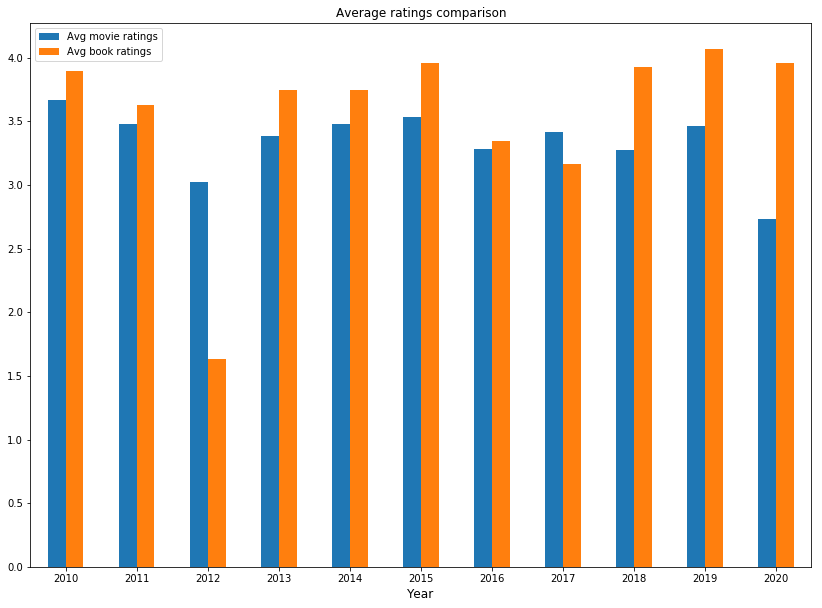

In [101]:
fig, ax = subplots()
pd_gb_ratings.plot.bar(rot = 0, title='Average ratings comparison',ax=ax, figsize = (14, 10))
ax.set_xlabel("Year",fontsize=12)
ax.legend(['Avg movie ratings', 'Avg book ratings']);